In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from glob import glob
import os
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
import torch

plt.style.use('../../figure_style.mplstyle')

import sys
sys.path.insert(0, '../src')

print(torch.cuda.is_available())

False


## 2D Poisson equation

$$ \nabla^2 u(x, y) = f(x, y) $$

Here we will make $f(x, y)$ the convolution of some point source distribution $\rho(x, y)$ with a gaussian kernel

Reduced functional loss: 0


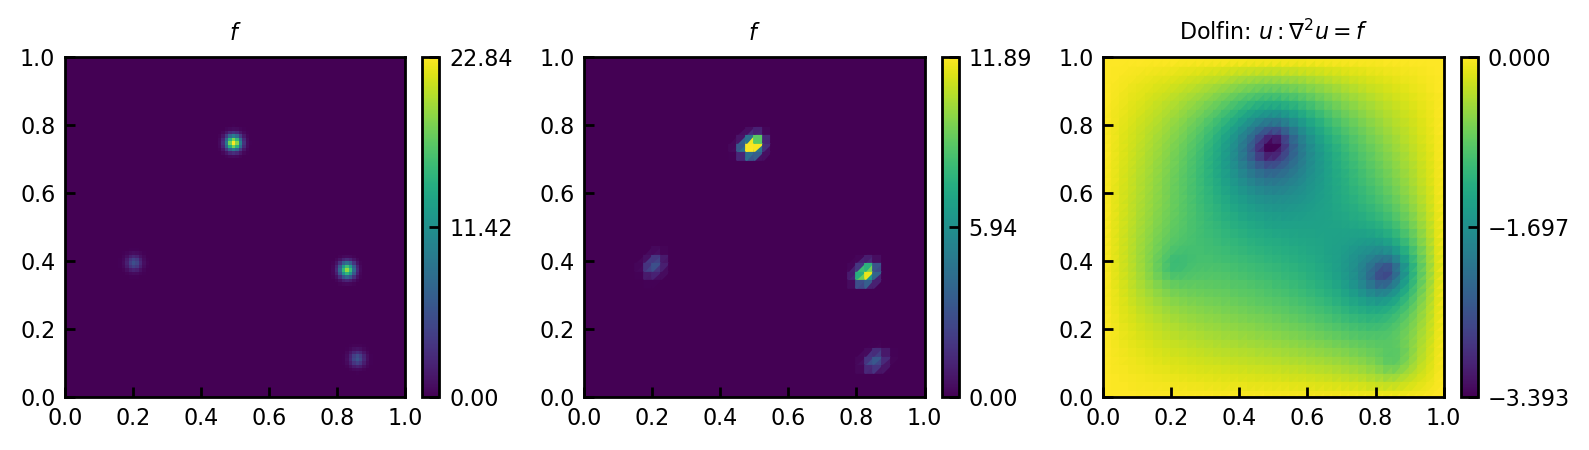

In [43]:
import ufl
import dolfin as dlf
import dolfin_adjoint as d_ad
import pyadjoint as pyad

# Turn off annoying log messages
import logging
logging.getLogger('FFC').setLevel(logging.ERROR)
dlf.set_log_level(40)

from plot_utils import *
from mesh_utils import *
from dolfin_problems import *
from scipy.ndimage import gaussian_filter

X = np.linspace(0, 1, 100)
Y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(X, Y, indexing='xy')
C = np.zeros_like(X)
inputs = np.stack([X, Y, C], axis=0)

mesh_size = 40
mesh = d_ad.UnitSquareMesh(nx=mesh_size, ny=mesh_size)
build_problem = BuildPoissonProblem(mesh)

def forcing_function(xyc):
    """ Convolution of point sources with gaussian """
    force = 1e3 * gaussian_filter(xyc[2:], sigma=(0, 1.5,1.5)) * np.sin(xyc[0:1]) * np.sin(xyc[1:2])
    return force
    
def make_force_outputs(inputs):
    inputs[2] = 0.
    for j in range(4):
        inputs[2, np.random.randint(10, 90), np.random.randint(10, 90)] += 1.

    force = forcing_function(inputs)
    force_mesh = multichannel_img_to_dofs(force, inputs[0], inputs[1], build_problem.function_space, return_function=True)
    output = build_problem.forward(force_mesh).compute_vertex_values()

    return inputs, force, force_mesh, output

inputs, force, force_mesh, output = make_force_outputs(inputs)
Jhat = build_problem.reduced_functional(output)
print(f'Reduced functional loss: {Jhat(force_mesh.vector()[:]):.3g}', flush=True)

# Plot and compare
fig, ax = plt.subplots(1, 3, figsize=(8,2.5))
ax = ax.flatten()

# Forcing function
plot_grid(ax[0], force[0], X, Y)
ax[0].set_title(r'$f$')

plot_mesh(ax[1], force_mesh.compute_vertex_values(), mesh)
ax[1].set_title(r'$f$')

# Dolfin solutions
plot_mesh(ax[2], output, mesh)
ax[2].set_title(r'Dolfin: $u: \nabla^2 u = f$')

for a in ax:
    a.set_aspect('equal')

plt.tight_layout()

Opened file for writing


100%|██████████| 256/256 [00:15<00:00, 16.44it/s]


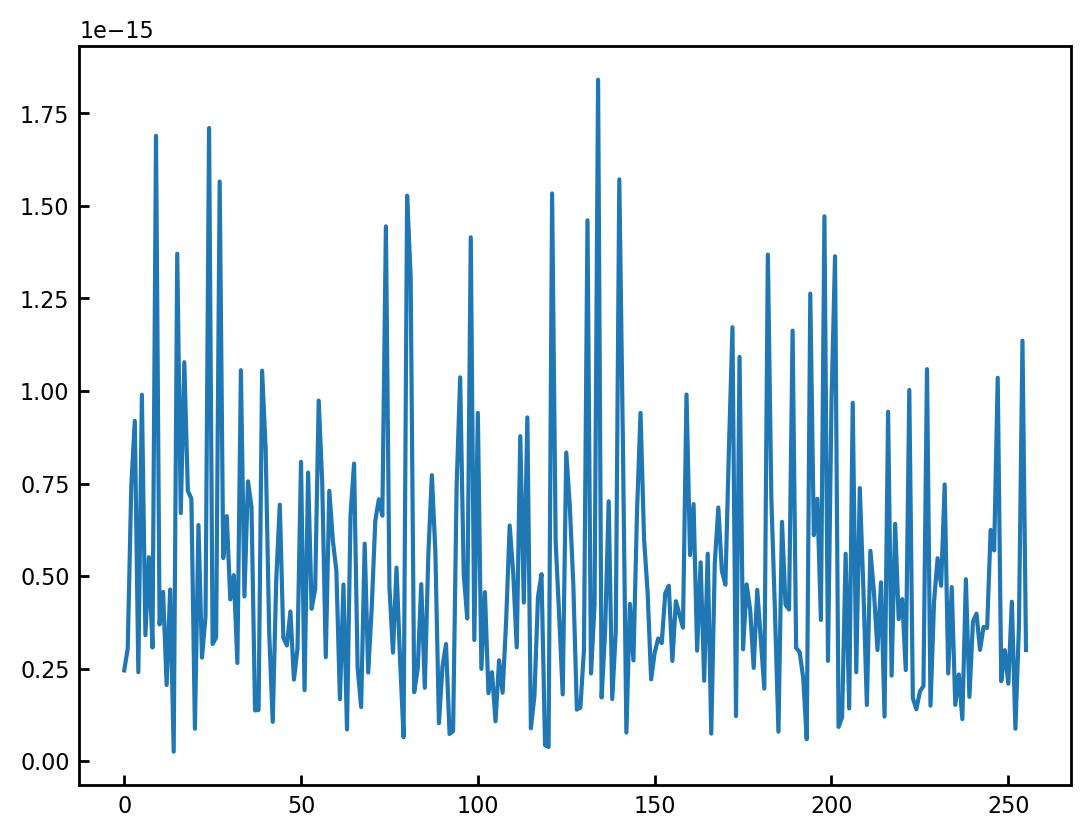

In [32]:
import h5py
from tqdm import trange

dataset_size = 256
build_problem = BuildPoissonProblem(mesh)

residuals = np.zeros(dataset_size)

with h5py.File('../data/poisson_dataset.hdf5', 'w') as h5f:
    print('Opened file for writing')
    h5f.attrs['dataset_size'] = dataset_size

    for i in trange(dataset_size):
        d_ad.set_working_tape(d_ad.Tape())
        group = h5f.create_group(f'{i:06d}')

        inputs, force, force_mesh, output = make_force_outputs(inputs)
    
        Jhat = build_problem.reduced_functional(output.astype(np.float32))
        residuals[i] = Jhat(force_mesh.vector()[:].astype(np.float32))

        group.create_dataset('inputs', data=inputs.astype(np.float32))
        group.create_dataset('force', data=force.astype(np.float32))
        group.create_dataset('output', data=output.astype(np.float32))

file = dlf.File('../data/square_mesh.xml')
file << mesh

fig, ax = plt.subplots(1,1)
ax.plot(residuals)

219: Reduced functional loss: 3.84e-16
079: Reduced functional loss: 6.47e-17
014: Reduced functional loss: 2.56e-17
245: Reduced functional loss: 6.25e-16


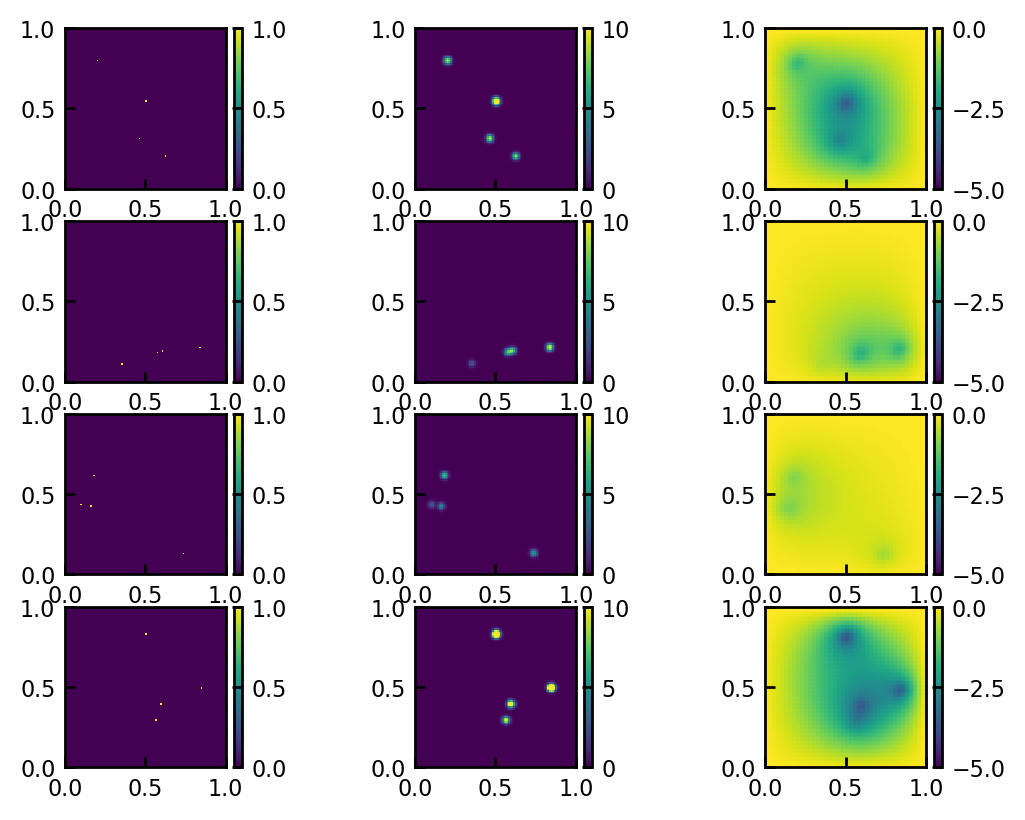

In [44]:
import h5py
fig, ax = plt.subplots(4, 3)

with h5py.File('../data/poisson_dataset.hdf5', 'r') as h5f:
    mesh = d_ad.Mesh('../data/square_mesh.xml')
    build_problem = BuildPoissonProblem(mesh)
    d_ad.set_working_tape(d_ad.Tape())

    N = h5f.attrs['dataset_size']

    for i in range(4):
        idx = np.random.randint(0, N)
        group = h5f[f'{idx:06d}']
        inputs = group['inputs'][()]
        force = group['force'][()]
        output = group['output'][()]
        plot_grid(ax[i,0], inputs[2], inputs[0], inputs[1])
        plot_grid(ax[i,1], force[0], inputs[0], inputs[1], vmin=0, vmax=10)
        plot_mesh(ax[i,2], output, mesh, vmin=-5, vmax=0)

        force_mesh = multichannel_img_to_dofs(force, inputs[0], inputs[1], build_problem.function_space, return_function=True) 
        Jhat = build_problem.reduced_functional(output)
        print(f'{idx:03d}: Reduced functional loss: {Jhat(force_mesh.vector()[:]):.3g}')

  0%|          | 0/256 [00:00<?, ?it/s]

100%|██████████| 256/256 [00:00<00:00, 9097.50it/s]


232: Reduced functional loss: 7.48e-16
094: Reduced functional loss: 7.42e-16
009: Reduced functional loss: 1.69e-15
000: Reduced functional loss: 2.45e-16


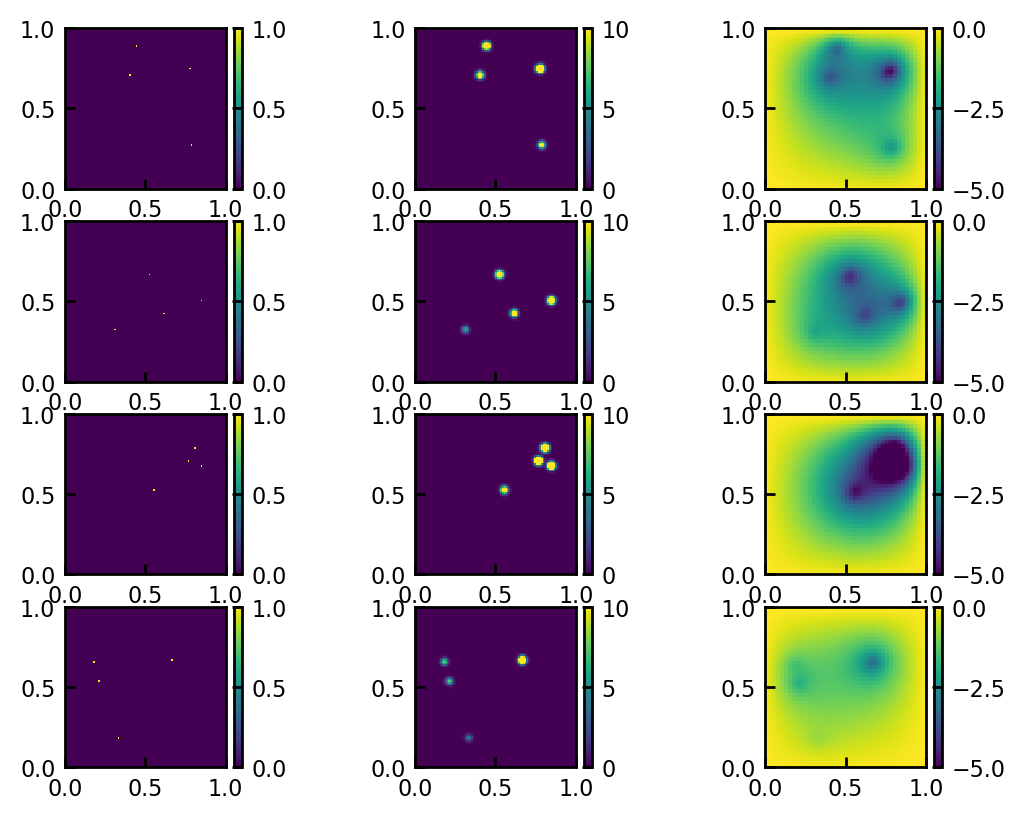

In [45]:
from data_processing import HDF5Dataset
dataset = HDF5Dataset(path='../data/poisson_dataset.hdf5', mesh='../data/square_mesh.xml', build_problem='dolfin_problems.BuildPoissonProblem')

fig, ax = plt.subplots(4, 3)

for i in range(4):
    d_ad.set_working_tape(d_ad.Tape())

    idx = np.random.randint(0, len(dataset))
    sample = dataset[idx]
    inputs = sample['inputs']
    force = sample['force']
    output = sample['output']

    plot_grid(ax[i,0], inputs[2], inputs[0], inputs[1])
    plot_grid(ax[i,1], force[0], inputs[0], inputs[1], vmin=0, vmax=10)
    plot_mesh(ax[i,2], output, dataset.mesh, vmin=-5, vmax=0)

    force_mesh = multichannel_img_to_dofs(force, inputs[0], inputs[1], build_problem.function_space, return_function=True) 
    Jhat = build_problem.reduced_functional(output)
    print(f'{idx:03d}: Reduced functional loss: {Jhat(force_mesh.vector()[:]):.3g}')

## 2D Incompressible Stokes equation

$$ \nabla^2 \mathbf{v} - \nabla p + \mathbf{f} = 0 $$

Subject to the incompressibility condition $\nabla \cdot \mathbf{v} = 0$

Reduced functional loss: 0


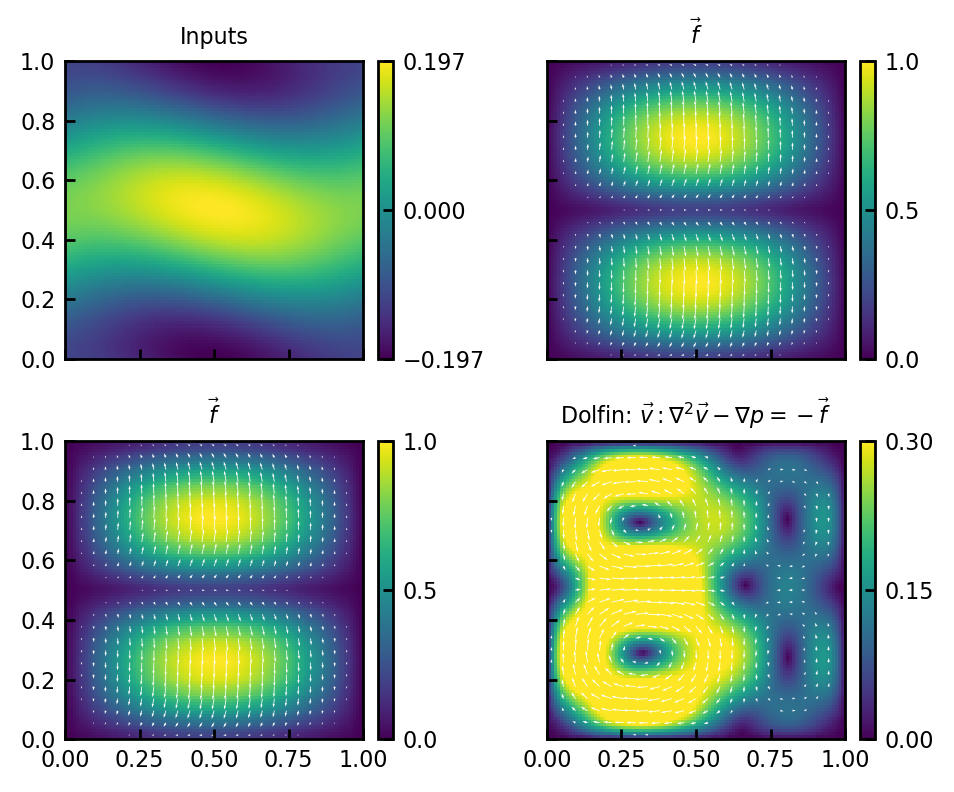

In [37]:
import ufl
import dolfin as dlf
import dolfin_adjoint as d_ad
import pyadjoint as pyad

# Turn off annoying log messages
import logging
logging.getLogger('FFC').setLevel(logging.ERROR)
dlf.set_log_level(40)

from plot_utils import *
from mesh_utils import *
from dolfin_problems import BuildStokesProblem
from scipy.ndimage import gaussian_filter

X = np.linspace(0, 1, 100)
Y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(X, Y, indexing='xy')
C = np.zeros(X.shape)
inputs = np.stack([X, Y, C], axis=0)

mesh = d_ad.Mesh('../data/square_mesh.xml')
build_problem = BuildStokesProblem(mesh)

d_ad.set_working_tape(d_ad.Tape())

def forcing_function(xyc):
    """ Convolution of point sources with gaussian """
    force = np.zeros([2, *xyc.shape[1:]])
    force[0] =  np.sin(xyc[0] * np.pi) * gaussian_filter(xyc[2], sigma=2)
    force[1] = -np.sin(xyc[0] * np.pi) * np.sin(xyc[1] * 2 * np.pi) * gaussian_filter(1 + 0.2 * xyc[2], sigma=2)
    return force

def make_force_outputs(inputs, kmax=4, num_features=2):
    # Random fourier feature
    rff = np.zeros([kmax, kmax])
    rff[np.random.randint(0, kmax, size=num_features), 
        np.random.randint(0, kmax, size=num_features)] += np.random.random(size=num_features)
    rff = np.fft.ifft2(rff, axes=(-2, -1), s=inputs.shape[-2:], norm='forward').real
    rff = np.fft.ifftshift(rff, axes=(-2, -1))
    inputs[2] = rff

    force = forcing_function(inputs)
    force_mesh = multichannel_img_to_dofs(force, inputs[0], inputs[1], build_problem.function_space, return_function=True)
    output = build_problem.forward(force_mesh).compute_vertex_values()
    output = output.reshape([2, -1])

    return inputs, force, force_mesh, output

inputs, force, force_mesh, output = make_force_outputs(inputs)
Jhat = build_problem.reduced_functional(output)
print(f'Reduced functional loss: {Jhat(force_mesh.vector()[:]):.3g}', flush=True)

# Plot and compare
fig, ax = plt.subplots(2, 2, figsize=(5, 4), sharex=True, sharey=True)
ax = ax.flatten()

# Input
plot_grid(ax[0], inputs[2], inputs[0], inputs[1])
ax[0].set_title('Inputs')

# Forcing function
plot_grid_vector(ax[1], force, inputs[0], inputs[1], vmin=0, vmax=1) 
ax[1].set_title(r'$\vec{f}$')

# Plot functions on mesh
plot_mesh_vector(ax[2], force_mesh.compute_vertex_values().reshape([2, -1]), mesh, vmin=0, vmax=1)
ax[2].set_title(r'$\vec{f}$')

# Dolfin solutions
plot_mesh_vector(ax[3], output, mesh, vmin=0, vmax=0.3)
ax[3].set_title(r'Dolfin: $\vec{v}: \nabla^2 \vec{v} - \nabla p = -\vec{f}$')

for a in ax:
    a.set_aspect('equal')

plt.tight_layout()

Opened file for writing


100%|██████████| 256/256 [01:42<00:00,  2.49it/s]


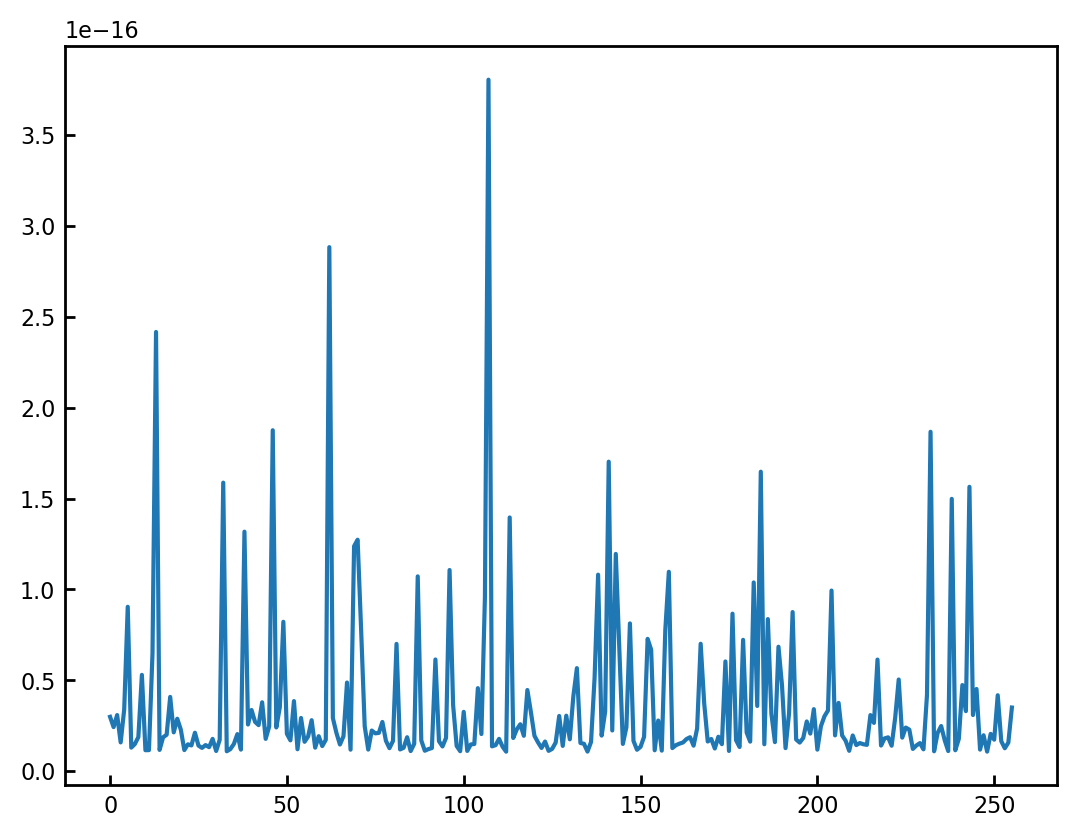

In [38]:
import h5py
from tqdm import trange

dataset_size = 256
build_problem = BuildStokesProblem(mesh)

residuals = np.zeros(dataset_size)

with h5py.File('../data/stokes_dataset.hdf5', 'w') as h5f:
    print('Opened file for writing')
    h5f.attrs['dataset_size'] = dataset_size

    for i in trange(dataset_size):
        d_ad.set_working_tape(d_ad.Tape())
        group = h5f.create_group(f'{i:06d}')

        inputs, force, force_mesh, output = make_force_outputs(inputs)
    
        Jhat = build_problem.reduced_functional(output.astype(np.float32))
        residuals[i] = Jhat(force_mesh.vector()[:])

        group.create_dataset('inputs', data=inputs.astype(np.float32))
        group.create_dataset('force', data=force.astype(np.float32))
        group.create_dataset('output', data=output.astype(np.float32))

fig, ax = plt.subplots(1,1)
ax.plot(residuals)

211: Reduced functional loss: 2.08e-06
118: Reduced functional loss: 1.88e-06
047: Reduced functional loss: 2.91e-06
125: Reduced functional loss: 7.45e-06


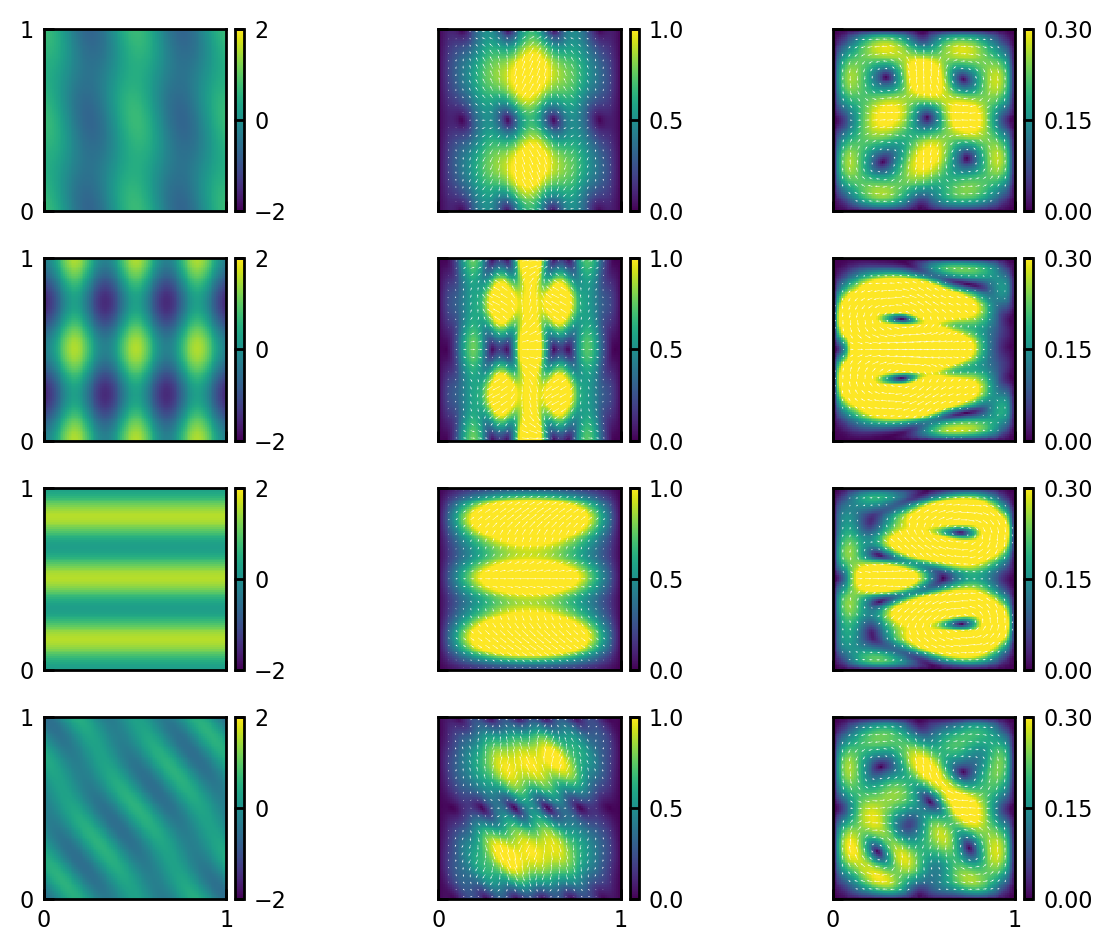

In [39]:
import h5py
fig, ax = plt.subplots(4, 3, sharex=True, sharey=True)

with h5py.File('../data/stokes_dataset.hdf5', 'r') as h5f:
    mesh = d_ad.Mesh('../data/square_mesh.xml')
    build_problem = BuildStokesProblem(mesh)
    d_ad.set_working_tape(d_ad.Tape())

    N = h5f.attrs['dataset_size']

    for i in range(4):
        idx = np.random.randint(0, N)
        group = h5f[f'{idx:06d}']
        inputs = group['inputs'][()]
        force = group['force'][()]
        output = group['output'][()]

        plot_grid(ax[i,0], inputs[2], inputs[0], inputs[1], vmin=-2, vmax=2)
        plot_grid_vector(ax[i,1], force, inputs[0], inputs[1], vmin=0, vmax=1)
        plot_mesh_vector(ax[i,2], output, mesh, vmin=0, vmax=0.3)

        force_mesh = multichannel_img_to_dofs(force, inputs[0], inputs[1], build_problem.function_space, return_function=True) 
        Jhat = build_problem.reduced_functional(output)
        print(f'{idx:03d}: Reduced functional loss: {Jhat(force_mesh.vector()[:]):.3g}')

for a in ax.flatten():
    a.set(xlim=[0, 1], ylim=[0, 1], xticks=[0, 1], yticks=[0, 1], aspect='equal')
    
plt.tight_layout()

  0%|          | 0/256 [00:00<?, ?it/s]

100%|██████████| 256/256 [00:00<00:00, 8637.82it/s]


159: Reduced functional loss: 6.72e-06
135: Reduced functional loss: 4.31e-06
089: Reduced functional loss: 3.78e-06
194: Reduced functional loss: 2.25e-06


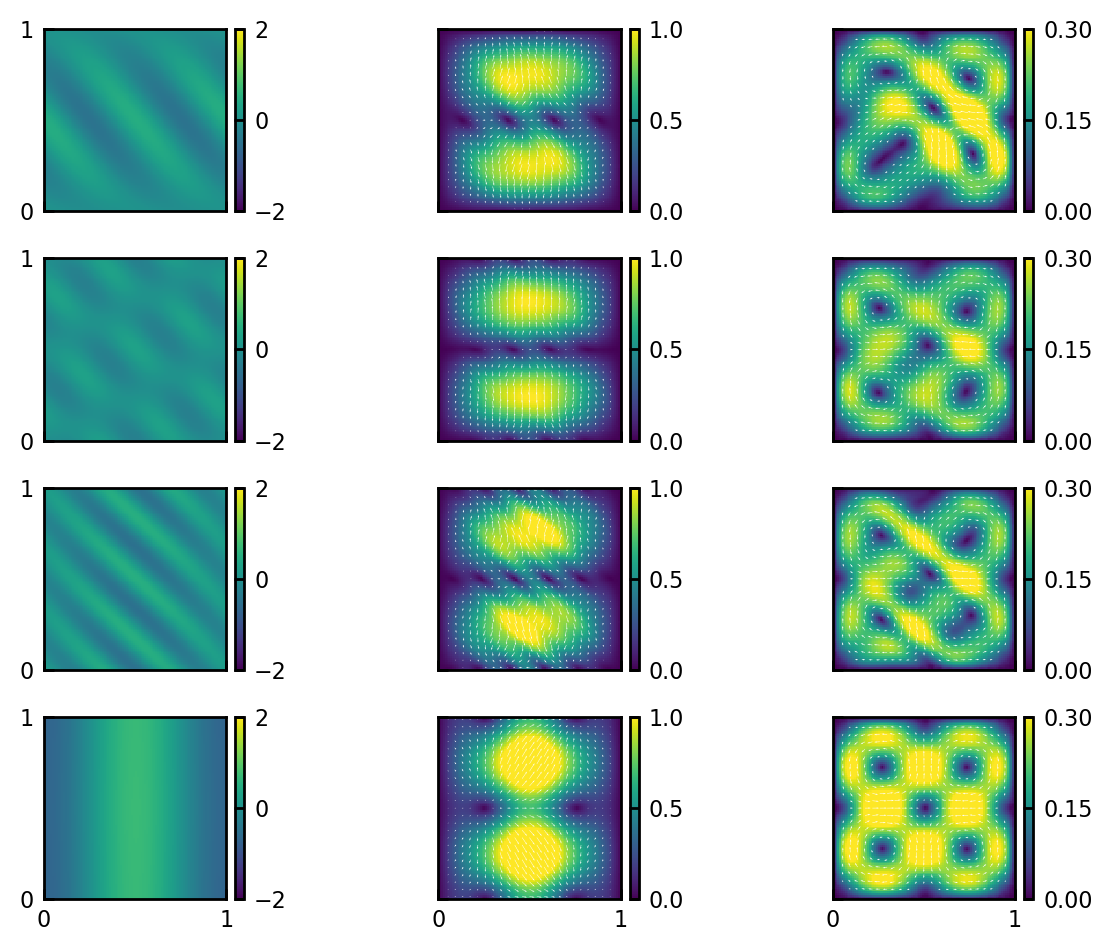

In [42]:
from data_processing import HDF5Dataset
dataset = HDF5Dataset(path='../data/stokes_dataset.hdf5', mesh='../data/square_mesh.xml', build_problem='dolfin_problems.BuildStokesProblem')

fig, ax = plt.subplots(4, 3, sharex=True, sharey=True)

for i in range(4):
    d_ad.set_working_tape(d_ad.Tape())

    idx = np.random.randint(0, len(dataset))
    sample = dataset[idx]
    inputs = sample['inputs']
    force = sample['force']
    output = sample['output']

    plot_grid(ax[i,0], inputs[2], inputs[0], inputs[1], vmin=-2, vmax=2)
    plot_grid_vector(ax[i,1], force, inputs[0], inputs[1], vmin=0, vmax=1)
    plot_mesh_vector(ax[i,2], output, mesh, vmin=0, vmax=0.3)

    force_mesh = multichannel_img_to_dofs(force, inputs[0], inputs[1], build_problem.function_space, return_function=True) 
    Jhat = build_problem.reduced_functional(output)
    print(f'{idx:03d}: Reduced functional loss: {Jhat(force_mesh.vector()[:]):.3g}')

for a in ax.flatten():
    a.set(xlim=[0, 1], ylim=[0, 1], xticks=[0, 1], yticks=[0, 1], aspect='equal')
    
plt.tight_layout()

## 2D Elasticity + Adhesion equation

$$ U = \int dA\, \bigg[ \frac{h}{2} \big( \sigma_{ij}^{el} + \sigma^a \delta_{ij} \big)  u_{ij} + \frac{1}{2} Y(x) \mathbf{u}^2 \bigg] $$

The coefficient $\mathbf{Y}(x)$ is a tunable parameter field that determines adhesion stiffness. Here the elastic stress obeys the constitutive relation:

$$ \sigma_{ij}^{el} = \frac{E}{1 + \nu} \bigg( u_{ij} + \frac{\nu}{1 - 2\nu} u_{kk} \delta_{ij} \bigg) $$

Where $E$ is the Young's modulus and $\nu$ is the Poisson ratio of the material. Minimization of this energy leads to the partial differential equations

$$ h \partial_{ij} \sigma_{ij}^{el} = Y(x) u_i \quad \text{(bulk)} $$ 
$$ \sigma_{ij}^{el} n_j = -\sigma_a n_i \quad \text{(boundary)} $$

For this problem, we take a circular domain and consider localized regions of large $Y(x)$. Other coefficients are taken to be known and fixed constants

In [15]:
import pygmsh
import meshio

with pygmsh.geo.Geometry() as geom:
    print(geom)
    geom.add_circle((0.5, 0.5), radius=0.4, mesh_size=0.02)
    mesh = geom.generate_mesh(dim=2)

print(mesh)
mesh = meshio.Mesh(
    points=mesh.points[:, :2],
    cells=[("triangle", mesh.cells_dict["triangle"])]
)
meshio.write('../data/circle_mesh.xml', mesh)

mesh = dlf.Mesh('../data/circle_mesh.xml')

mesh

<pygmsh Geometry object>
<meshio mesh object>
  Number of points: 1552
  Number of cells:
    line: 126
    triangle: 2974
    vertex: 4


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Reduced functional loss: 6.64e-06


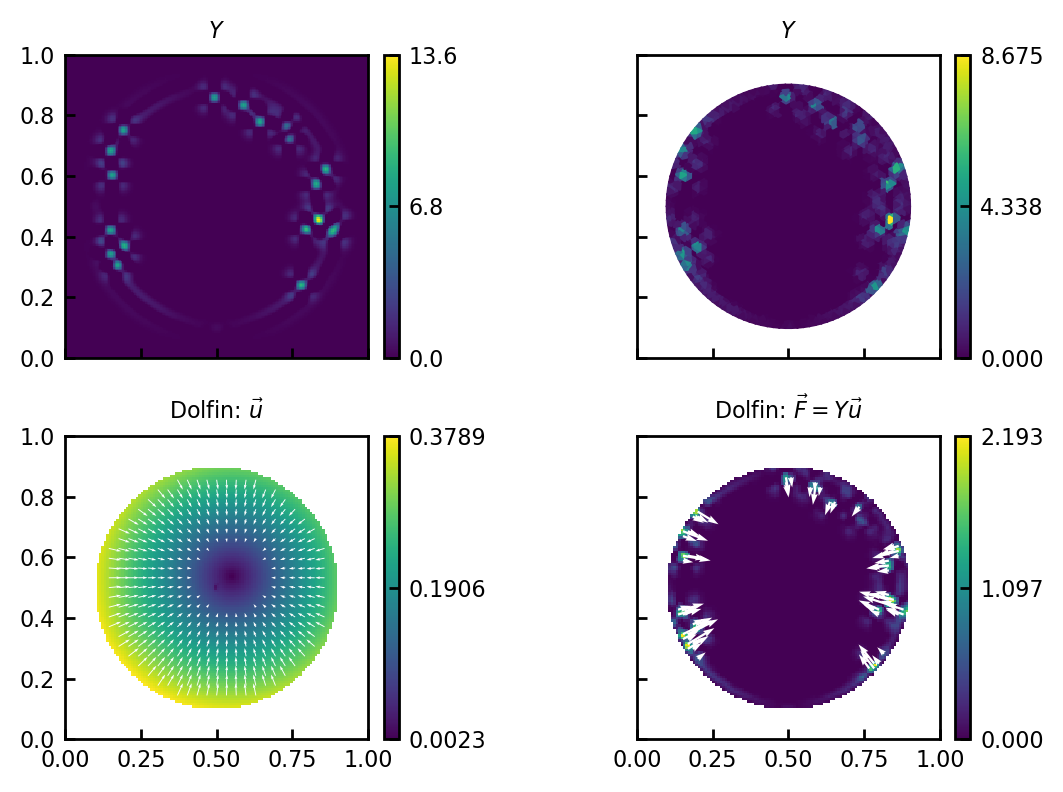

In [49]:
import ufl
import dolfin as dlf
import dolfin_adjoint as d_ad
import pyadjoint as pyad

# Turn off annoying log messages
import logging
logging.getLogger('FFC').setLevel(logging.ERROR)
dlf.set_log_level(40)

from plot_utils import *
from mesh_utils import *
from dolfin_problems import BuildElasticityAdhesionProblem
from scipy.ndimage import gaussian_filter

X = np.linspace(0, 1, 200)
Y = np.linspace(0, 1, 200)
X, Y = np.meshgrid(X, Y, indexing='xy')
C = np.zeros(X.shape)
inputs = np.stack([X, Y, C], axis=0)

mesh = d_ad.Mesh('../data/circle_mesh.xml')
build_problem = BuildElasticityAdhesionProblem(mesh)

d_ad.set_working_tape(d_ad.Tape())

def forcing_function(xyc):
    """ Convolution of point sources with gaussian """
    inp = xyc[2:]
    Y = 5e8 * -gaussian_filter(inp, sigma=4, order=2)
    Y[Y < 0] = 0.
    return Y

def make_force_outputs(inputs, r_min=0.3, r_max=0.4):
    r = np.sqrt((inputs[0] - 0.5)**2 + (inputs[1] - 0.5)**2)
    mask = r < r_max
    allowed = np.argwhere(np.logical_and(r >= r_min, r < r_max))
    inputs[2] = 0.
    inputs[2, mask] = 0.1

    for j in range(20):
        idx = np.random.randint(0, len(allowed))
        point = allowed[idx]
        inputs[2, point[0], point[1]] += 10.

    force = forcing_function(inputs)
    force_mesh = multichannel_img_to_dofs(force, inputs[0], inputs[1], build_problem.function_space, return_function=True)
    
    output = build_problem.forward(force_mesh).compute_vertex_values()
    output = output.reshape([2, -1])

    return inputs, force, force_mesh, output

inputs, force, force_mesh, output = make_force_outputs(inputs)
true_output = output * force_mesh.compute_vertex_values()
Jhat = build_problem.reduced_functional(true_output)
print(f'Reduced functional loss: {Jhat(force_mesh.vector()[:]):.3g}', flush=True)

# Plot and compare
fig, ax = plt.subplots(2, 2, figsize=(6, 4), sharex=True, sharey=True)
ax = ax.flatten()

# Forcing function
plot_grid(ax[0], force[0], X, Y, vmin=0)
ax[0].set_title(r'$Y$')

plot_mesh(ax[1], force_mesh.compute_vertex_values(), mesh, vmin=0)
ax[1].set_title(r'$Y$')

plot_mesh_vector(ax[2], output, mesh, N=100, downscale=4)
ax[2].set_title(r'Dolfin: $\vec{u}$')

plot_mesh_vector(ax[3], true_output, mesh, downscale=2, threshold=0.5)
ax[3].set_title(r'Dolfin: $\vec{F} = Y \vec{u}$')


for a in ax:
    a.set(xlim=[0, 1], ylim=[0, 1])
    a.set_aspect('equal')

plt.tight_layout()

Opened file for writing


100%|██████████| 256/256 [01:06<00:00,  3.88it/s]


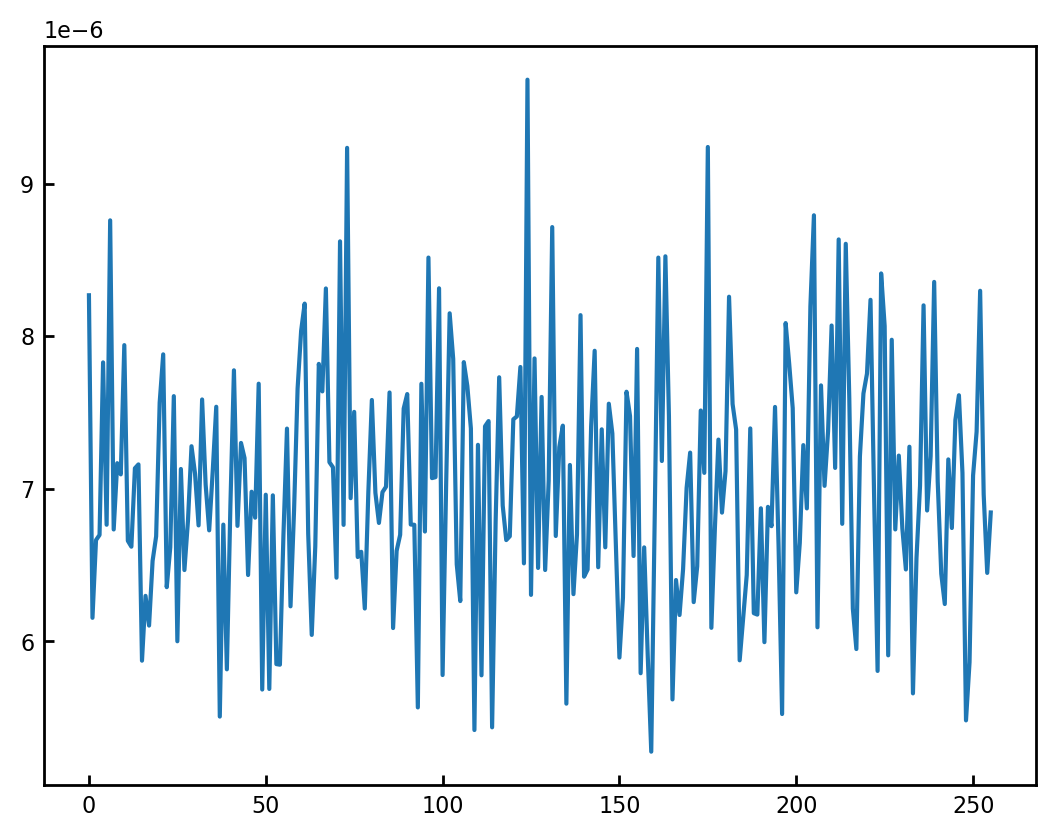

In [61]:
import h5py
from tqdm import trange

dataset_size = 256
build_problem = BuildElasticityAdhesionProblem(mesh)

residuals = np.zeros(dataset_size)


with h5py.File('../data/elasticity_adhesion_dataset.hdf5', 'w') as h5f:
    print('Opened file for writing')
    h5f.attrs['dataset_size'] = dataset_size

    h5f.create_dataset('inputs', shape=[dataset_size, *inputs.shape], dtype=np.float32)
    h5f.create_dataset('forces', shape=[dataset_size, 1, *inputs.shape[1:]], dtype=np.float32)
    h5f.create_dataset('outputs', shape=[dataset_size, 2, mesh.coordinates().shape[0]])

    for i in trange(dataset_size):
        d_ad.set_working_tape(d_ad.Tape())
        group = h5f.create_group(f'{i:06d}')

        inputs, force, force_mesh, output = make_force_outputs(inputs)
        true_output = output * force_mesh.compute_vertex_values()
        Jhat = build_problem.reduced_functional(true_output)
        residuals[i] = Jhat(force_mesh.vector()[:])

        group.create_dataset('inputs', data=inputs.astype(np.float32))
        group.create_dataset('force', data=force.astype(np.float32))
        group.create_dataset('output', data=true_output.astype(np.float32))

fig, ax = plt.subplots(1,1)
ax.plot(residuals)

050: Reduced functional loss: 6.96e-06
155: Reduced functional loss: 7.92e-06
151: Reduced functional loss: 6.29e-06
198: Reduced functional loss: 7.82e-06


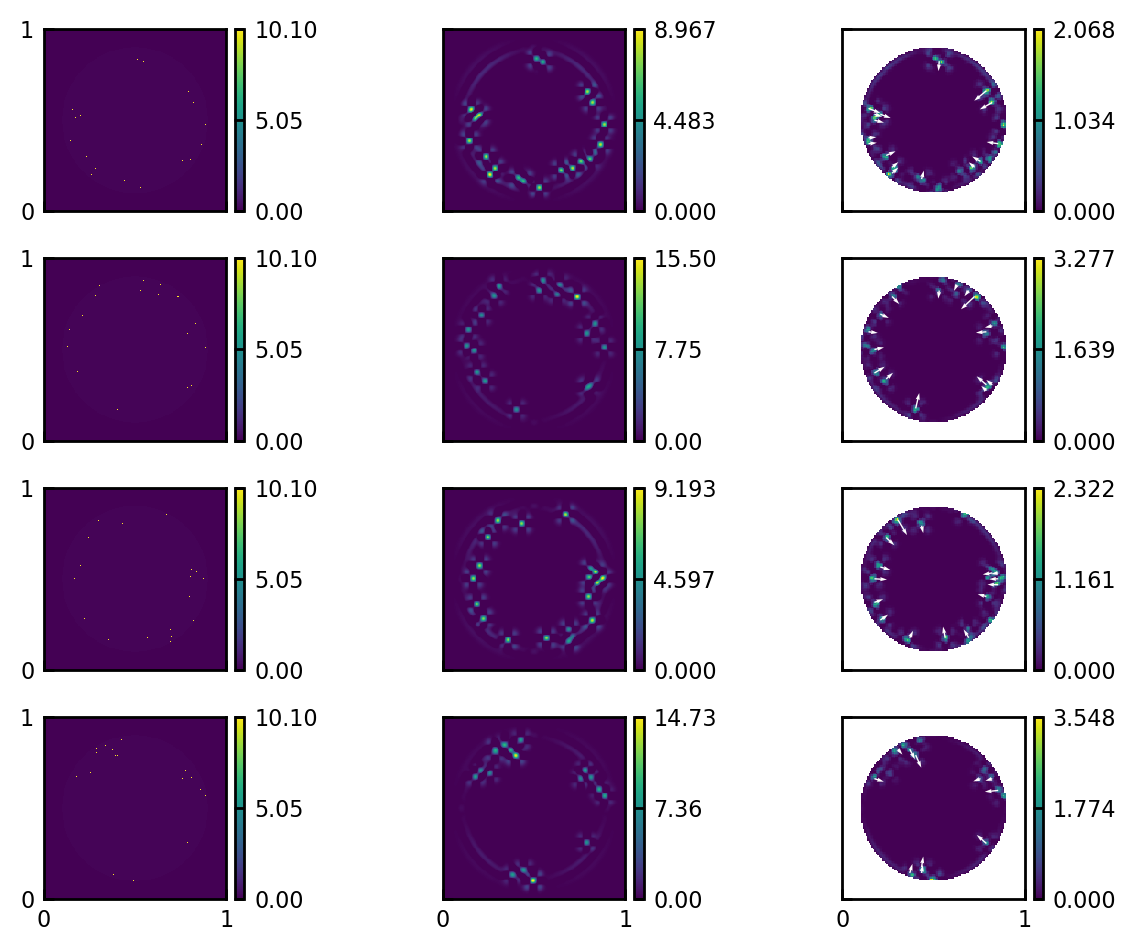

In [62]:
import h5py
fig, ax = plt.subplots(4, 3, sharex=True, sharey=True)

with h5py.File('../data/elasticity_adhesion_dataset.hdf5', 'r') as h5f:
    mesh = d_ad.Mesh('../data/circle_mesh.xml')
    build_problem = BuildElasticityAdhesionProblem(mesh)
    d_ad.set_working_tape(d_ad.Tape())

    N = h5f.attrs['dataset_size']

    for i in range(4):
        idx = np.random.randint(0, N)
        group = h5f[f'{idx:06d}']
        inputs = group['inputs'][()]
        force = group['force'][()]
        output = group['output'][()]

        plot_grid(ax[i,0], inputs[2], inputs[0], inputs[1])
        plot_grid(ax[i,1], force[0], inputs[0], inputs[1])
        plot_mesh_vector(ax[i, 2], output, mesh, downscale=4, threshold=0.5)

        force_mesh = multichannel_img_to_dofs(force, inputs[0], inputs[1], build_problem.function_space, return_function=True) 
        Jhat = build_problem.reduced_functional(output)
        print(f'{idx:03d}: Reduced functional loss: {Jhat(force_mesh.vector()[:]):.3g}')

for a in ax.flatten():
    a.set(xlim=[0, 1], ylim=[0, 1], xticks=[0, 1], yticks=[0, 1], aspect='equal')
    
plt.tight_layout()

100%|██████████| 256/256 [00:00<00:00, 995.30it/s]


100%|██████████| 256/256 [00:00<00:00, 9073.98it/s]


220: Reduced functional loss: 7.75e-06
008: Reduced functional loss: 7.17e-06
204: Reduced functional loss: 8.2e-06
115: Reduced functional loss: 6.79e-06


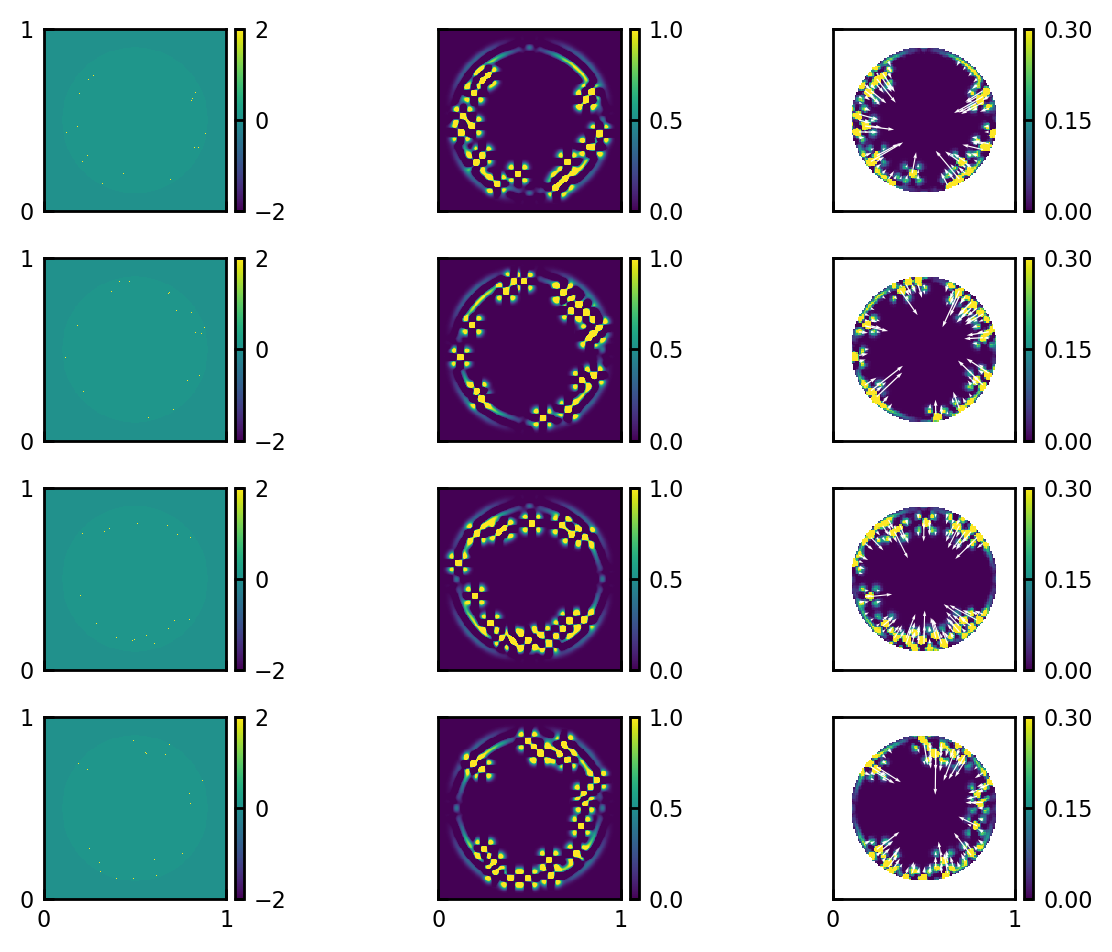

In [63]:
from data_processing import HDF5Dataset
dataset = HDF5Dataset(path='../data/elasticity_adhesion_dataset.hdf5', mesh='../data/circle_mesh.xml', build_problem='dolfin_problems.BuildElasticityAdhesionProblem')

fig, ax = plt.subplots(4, 3, sharex=True, sharey=True)

for i in range(4):
    d_ad.set_working_tape(d_ad.Tape())

    idx = np.random.randint(0, len(dataset))
    sample = dataset[idx]
    inputs = sample['inputs']
    force = sample['force']
    output = sample['output']

    plot_grid(ax[i,0], inputs[2], inputs[0], inputs[1], vmin=-2, vmax=2)
    plot_grid(ax[i,1], force[0], inputs[0], inputs[1], vmin=0, vmax=1)
    plot_mesh_vector(ax[i,2], output, mesh, vmin=0, vmax=0.3)

    force_mesh = multichannel_img_to_dofs(force, inputs[0], inputs[1], build_problem.function_space, return_function=True) 
    Jhat = build_problem.reduced_functional(output)
    print(f'{idx:03d}: Reduced functional loss: {Jhat(force_mesh.vector()[:]):.3g}')

for a in ax.flatten():
    a.set(xlim=[0, 1], ylim=[0, 1], xticks=[0, 1], yticks=[0, 1], aspect='equal')
    
plt.tight_layout()